# SM06: Exploratory Data Analysis

When working with a new dataset, the first priority is to get a feel for the data. Some of the things that effect data wrangling are:

- Null values
- Data types
- Distribution
- Frequency

For more information on EDA, see [Entry 5: Explore the Data](https://julielinx.github.io/blog/05_EDA/) and its [accompanying notebook](https://github.com/julielinx/datascience_diaries/blob/master/01_ml_process/05_nb_EDA_viz.ipynb).

## Prerequisites

Per usual, I'll assume that SageMaker Studio and an IAM role with the appropriate permissions have been set up. For more information on these two topics, see the Prerequisites section of [SM01]().

I'll also assume that the clean data is stored in the appropriate location in S3. To get this data, run the Python script and SageMaker Pipeline in [SM05]().

## The Dataset

Whenever I load new data, pretty much the first thing I do is to take a look at a sample of the data. I just use the `head()` function, but `tail()` works just as well. Sometimes I do both because the rows at the beginning of a dataset can look very different from those in the middle or at the end.

In this first glimpse of the data, I can see that the reverse engineering of the two categorical columns worked and that the headers have been appropriately applied.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sagemaker.session

session = sagemaker.session.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
prefix = '1_ins_dataset'

df = pd.read_csv(f's3://{bucket}/{prefix}/clean/full_data.csv')

In [5]:
df.head()

,zip_agg Customer Subtype,zip_agg Number of houses,zip_agg Avg size household,zip_agg Avg age,zip_agg Customer main type,zip_agg Roman catholic,zip_agg Protestant,zip_agg Other religion,zip_agg No religion,zip_agg Married,...,Nbr private accident ins policies,Nbr family accidents ins policies,Nbr disability ins policies,Nbr fire policies,Nbr surfboard policies,Nbr boat policies,Nbr bicycle policies,Nbr property ins policies,Nbr ss ins policies,Nbr mobile home policies
0,Lower class large families,1,3,2,Family with grown ups,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,Mixed small town dwellers,1,2,2,Family with grown ups,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,Mixed small town dwellers,1,2,2,Family with grown ups,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,"Modern, complete families",1,3,3,Average Family,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,Large family farms,1,4,2,Farmers,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


### Curated data

Curated datasets have a lot of limitations when it comes to emulating production data. For starters, curated datasets tend to come preprocessed. My biggest beef with this is that the way data is processed can make a big difference in the efficacy of a model.

An example of preprocessing in the [Insurance Company Benchmark (COIL 2000) dataset](https://archive.ics.uci.edu/ml/datasets/Insurance+Company+Benchmark+%28COIL+2000%29) data set are the columns that used to start with 'M'. Per the Data Set Information section 

> Note: All the variables starting with M are zipcode variables. They give information on the distribution of that variable, e.g. Rented house, in the zipcode area of the customer.

As such, I relabeled these columns to start with 'zip_agg' to remind myself that they're aggregate variables. Most of these columns have values that fall into the 0-9 range. As there are obviously more than nine households in (most) zip codes, these probably aren't direct counts, they're probably binned or normalized somehow. This means that if I want to try to apply my model to a new data point, say my neighbor, it would be extremely difficult to collect and measure the correct features.

However, when prototyping, the ability to generate new observations isn't necessarily a deal breaker. Reserving some data for testing can replicate new data points well enough. In a production system, the generation of new data may not be easily reproduced at any time except the time of capture. As long as the logic is spelled out and well understood, then these features may as well be treated like aggregated black-boxes at the time of training, just like the aggregated zip code variables of the Insurance Company data set.

### Missing values

Missing, or null, values can cause a lot of problems in a production pipeline. These problems range from functions that error out during processing to models that won't train with null values. For more context on missing values see [Entry 12: Missing Values](https://julielinx.github.io/blog/12_missing_values/).

The `info()` function provides information on null values, specifically the `Non-Null Count`. By comparing this number with the entries count in `RangeIndex` I can also determine how many (if any) null values will need to be addressed.

*Note*, the function will cut out the `Non-Null Counts` if the number of columns exceeds the `pandas.options.display.max_info_columns` setting. To get around this, use the parameter `show_counts=True` (`df.info(show_counts=True`).

### Data types

The `info()` function also shows the data type (`Dtype`) for each column. This makes it easy to see that the data type for all columns except the two I purposeful transformed into text, are numeric - specifically `int64`. Data types dictate the kinds of functions and transformations that can be performed on any given column.

Data type also effects the amount of memory required to store the data. The `memory usage` for the dataframe is listed at the bottom of `info()` output. This dataframe is 6.4+MB.

*Note*, when working with large datasets on constrained resources (or to reduce costs and chose to use smaller resources) it can be useful to change the data type to lower memory usage. For context and directions on memory usage reduction, check out any of the following articles:

- [How to reduce memory usage in Python (Pandas)?](https://www.analyticsvidhya.com/blog/2021/04/how-to-reduce-memory-usage-in-python-pandas/)
- [Memory Efficient Data Science: Types](https://towardsdatascience.com/memory-efficient-data-science-types-53423d48ba1d)
- [Reducing memory usage in pandas with smaller datatypes](https://towardsdatascience.com/reducing-memory-usage-in-pandas-with-smaller-datatypes-b527635830af)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9822 entries, 0 to 9821
Data columns (total 86 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   zip_agg Customer Subtype               9822 non-null   object
 1   zip_agg Number of houses               9822 non-null   int64 
 2   zip_agg Avg size household             9822 non-null   int64 
 3   zip_agg Avg age                        9822 non-null   int64 
 4   zip_agg Customer main type             9822 non-null   object
 5   zip_agg Roman catholic                 9822 non-null   int64 
 6   zip_agg Protestant                     9822 non-null   int64 
 7   zip_agg Other religion                 9822 non-null   int64 
 8   zip_agg No religion                    9822 non-null   int64 
 9   zip_agg Married                        9822 non-null   int64 
 10  zip_agg Living together                9822 non-null   int64 
 11  zip_agg Other rel

## EDA (Exploratory Data Analysis)

I'm one of those people that needs to see and manipulate something to understand it. This is especially true of data. When faced with a description of the data, it feels sterile and devoid of meaning:

> Information about customers consists of 86 variables and includes product usage data and socio-demographic data derived from zip area codes. The data was supplied by the Dutch data mining company Sentient Machine Research and is based on a real world business problem. The training set contains over 5000 descriptions of customers, including the information of whether or not they have a caravan insurance policy. A test set contains 4000 customers of whom only the organisers know if they have a caravan insurance policy.

> The data dictionary ([Web Link]) describes the variables used and their values.

> Note: All the variables starting with M are zipcode variables. They give information on the distribution of that variable, e.g. Rented house, in the zipcode area of the customer.

> One instance per line with tab delimited fields.

> TICDATA2000.txt: Dataset to train and validate prediction models and build a description (5822 customer records). Each record consists of 86 attributes, containing sociodemographic data (attribute 1-43) and product ownership (attributes 44-86).The sociodemographic data is derived from zip codes. All customers living in areas with the same zip code have the same sociodemographic attributes. Attribute 86, "CARAVAN:Number of mobile home policies", is the target variable.

> TICEVAL2000.txt: Dataset for predictions (4000 customer records). It has the same format as TICDATA2000.txt, only the target is missing. Participants are supposed to return the list of predicted targets only. All datasets are in tab delimited format. The meaning of the attributes and attribute values is given below.

> TICTGTS2000.txt Targets for the evaluation set.

There's some very useful information in there, but I never end up figuring out what until I've had a chance to look at the actual data.

## Frequency

One of my favorite methods for EDA is `.value_counts()`. There's just something about seeing feature values with their frequency count that brings the data info focus.

In [7]:
for col in df.columns:
    print(col)
    display(df[col].value_counts(dropna=False))
    print('\n')

zip_agg Customer Subtype


Lower class large families                    1401
Traditional families                           569
Middle class families                          546
Large religous families                        542
Modern, complete families                      460
High status seniors                            433
Young and rising                               376
Couples with teens 'Married with children'     373
Village families                               362
Mixed rurals                                   355
Large family, employed child                   325
Young, low educated                            324
Low income catholics                           318
Mixed seniors                                  304
Young all american family                      302
Family starters                                286
Stable family                                  271
Mixed small town dwellers                      233
High Income, expensive child                   218
Career and childcare           



zip_agg Number of houses


1     8915
2      821
3       64
7        8
4        4
5        3
6        3
10       2
8        2
Name: zip_agg Number of houses, dtype: int64



zip_agg Avg size household


3    4513
2    3616
4    1132
1     452
5     106
6       3
Name: zip_agg Avg size household, dtype: int64



zip_agg Avg age


3    5154
2    2409
4    1777
5     329
1     104
6      49
Name: zip_agg Avg age, dtype: int64



zip_agg Customer main type


Family with grown ups    2694
Average Family           1513
Conservative families    1111
Successful hedonists      959
Living well               940
Retired and Religeous     881
Driven Growers            827
Farmers                   492
Cruising Seniors          326
Career Loners              79
Name: zip_agg Customer main type, dtype: int64



zip_agg Roman catholic


0    5420
1    2744
2    1213
3     243
4     123
5      30
6      25
7      11
9      10
8       3
Name: zip_agg Roman catholic, dtype: int64



zip_agg Protestant


4    2666
5    2533
6    1180
3    1022
7     995
2     666
9     290
1     225
0     127
8     118
Name: zip_agg Protestant, dtype: int64



zip_agg Other religion


0    3460
1    3391
2    2294
3     415
4     220
5      42
Name: zip_agg Other religion, dtype: int64



zip_agg No religion


3    2476
4    2245
2    1778
5    1572
0     773
6     394
1     378
7     179
9      14
8      13
Name: zip_agg No religion, dtype: int64



zip_agg Married


7    2800
6    2015
5    1628
9    1345
8     603
4     550
3     402
2     252
1     119
0     108
Name: zip_agg Married, dtype: int64



zip_agg Living together


0    4185
1    3402
2    1790
3     260
4     133
5      32
6      18
7       2
Name: zip_agg Living together, dtype: int64



zip_agg Other relation


2    2944
0    1981
3    1965
4    1140
1     900
5     421
6     299
7     100
9      41
8      31
Name: zip_agg Other relation, dtype: int64



zip_agg Singles


0    2916
2    2143
1    1619
3    1439
4     890
5     416
6     222
7     107
8      36
9      34
Name: zip_agg Singles, dtype: int64



zip_agg Household without children


3    2517
4    2493
2    1798
5    1043
0     613
1     608
6     516
7     160
9      47
8      27
Name: zip_agg Household without children, dtype: int64



zip_agg Household with children


4    1983
5    1869
3    1596
6    1322
2    1096
7     601
1     475
8     341
9     296
0     243
Name: zip_agg Household with children, dtype: int64



zip_agg High level education


0    3621
1    2176
2    1921
3     927
4     577
5     338
6     123
7      83
8      39
9      17
Name: zip_agg High level education, dtype: int64



zip_agg Medium level education


4    2394
3    2332
2    1648
5    1227
0     711
1     624
6     526
7     243
9      64
8      53
Name: zip_agg Medium level education, dtype: int64



zip_agg Lower level education


5    1740
6    1472
4    1448
3    1128
2    1099
7    1090
9     531
0     494
8     424
1     396
Name: zip_agg Lower level education, dtype: int64



zip_agg High status


0    2576
2    2278
1    2119
3    1282
4     641
5     415
6     248
7     159
9      57
8      47
Name: zip_agg High status, dtype: int64



zip_agg Entrepreneur


0    7031
1    2009
2     600
5      94
3      70
4      18
Name: zip_agg Entrepreneur, dtype: int64



zip_agg Farmer


0    6985
1    1462
2     815
3     256
4     144
5     108
6      21
8      15
9      13
7       3
Name: zip_agg Farmer, dtype: int64



zip_agg Middle management


2    2508
3    2348
4    1573
0    1164
5     726
1     699
6     348
7     295
9     137
8      24
Name: zip_agg Middle management, dtype: int64



zip_agg Skilled labourers


2    2327
0    1995
3    1967
1    1523
4    1006
5     524
6     299
7     119
8      38
9      24
Name: zip_agg Skilled labourers, dtype: int64



zip_agg Unskilled labourers


2    2460
3    1817
1    1685
0    1636
4    1289
5     564
6     216
7     101
9      37
8      17
Name: zip_agg Unskilled labourers, dtype: int64



zip_agg Social class A


0    2871
1    2626
2    2056
3    1168
4     452
5     228
6     152
7     147
9     106
8      16
Name: zip_agg Social class A, dtype: int64



zip_agg Social class B1


2    3009
1    2549
0    2275
3    1300
4     459
5     129
6      53
9      26
8      13
7       9
Name: zip_agg Social class B1, dtype: int64



zip_agg Social class B2


2    2778
3    2025
0    1694
1    1434
4    1104
5     588
6     176
8      11
7       9
9       3
Name: zip_agg Social class B2, dtype: int64



zip_agg Social class C


5    1953
4    1929
3    1845
2    1468
6     800
0     634
1     478
7     396
9     202
8     117
Name: zip_agg Social class C, dtype: int64



zip_agg Social class D


0    4376
1    2658
2    1434
3     757
4     378
5     158
6      37
7      22
9       1
8       1
Name: zip_agg Social class D, dtype: int64



zip_agg Rented house


0    1663
9    1255
2    1177
3     961
4     908
8     874
5     863
1     755
7     710
6     656
Name: zip_agg Rented house, dtype: int64



zip_agg Home owners


9    1663
0    1255
7    1185
6     978
5     912
1     871
4     834
8     756
2     712
3     656
Name: zip_agg Home owners, dtype: int64



zip_agg 1 car


6    2822
7    2338
5    2106
9     829
4     740
8     435
3     400
2     102
0      30
1      20
Name: zip_agg 1 car, dtype: int64



zip_agg 2 cars


0    3078
2    2999
1    2454
3     638
4     531
5     105
6      14
7       2
9       1
Name: zip_agg 2 cars, dtype: int64



zip_agg No car


2    2611
0    2475
3    1871
1    1327
4    1020
5     288
6     145
7      40
9      27
8      18
Name: zip_agg No car, dtype: int64



zip_agg National Health Service


7    2520
5    1644
6    1451
9    1436
8    1178
4     628
2     518
3     315
0     109
1      23
Name: zip_agg National Health Service, dtype: int64



zip_agg Private health insurance


2    2520
4    1668
0    1436
3    1415
1    1178
5     639
7     518
6     316
9     109
8      23
Name: zip_agg Private health insurance, dtype: int64



zip_agg Income < 30.000


0    2164
2    1893
3    1826
1    1060
4     981
5     971
6     512
7     261
9      78
8      76
Name: zip_agg Income < 30.000, dtype: int64



zip_agg Income 30-45.000


4    2207
3    1989
5    1585
2    1569
0     782
6     671
1     486
7     337
9     134
8      62
Name: zip_agg Income 30-45.000, dtype: int64



zip_agg Income 45-75.000


3    2028
2    1962
4    1709
0    1505
1    1132
5     828
6     232
7     170
9     161
8      95
Name: zip_agg Income 45-75.000, dtype: int64



zip_agg Income 75-122.000


0    5464
1    2251
2    1256
3     429
4     278
5     119
6      10
8       7
9       6
7       2
Name: zip_agg Income 75-122.000, dtype: int64



zip_agg Income >123.000


0    8253
1    1269
2     188
3      66
4      38
5       4
6       2
9       1
7       1
Name: zip_agg Income >123.000, dtype: int64



zip_agg Average income


3    3232
4    3063
5    1268
2    1110
6     646
7     228
8     121
1      78
9      38
0      38
Name: zip_agg Average income, dtype: int64



zip_agg Purchasing power class


3    2556
6    1587
4    1539
5     964
1     938
7     777
2     731
8     730
Name: zip_agg Purchasing power class, dtype: int64



Contri private third party ins


0    5903
2    3562
1     341
3      16
Name: Contri private third party ins, dtype: int64



Contri third party ins (firms)


0    9688
2      53
3      36
4      26
1       9
6       5
5       5
Name: Contri third party ins (firms), dtype: int64



Contri third party ins (agriculture)


0    9613
4     108
3      92
2       7
1       2
Name: Contri third party ins (agriculture), dtype: int64



Contri car policies


0    4825
6    3910
5    1013
7      64
8       5
4       4
9       1
Name: Contri car policies, dtype: int64



Contri delivery van policies


0    9730
6      71
5      17
7       4
Name: Contri delivery van policies, dtype: int64



Contri motorcycle/scooter policies


0    9460
4     207
6      79
5      70
3       4
7       2
Name: Contri motorcycle/scooter policies, dtype: int64



Contri lorry policies


0    9808
6      10
7       2
4       1
9       1
Name: Contri lorry policies, dtype: int64



Contri trailer policies


0    9719
2      62
1      30
3       9
5       1
4       1
Name: Contri trailer policies, dtype: int64



Contri tractor policies


0    9576
3     142
4      45
5      42
6      16
7       1
Name: Contri tractor policies, dtype: int64



Contri agricultural machines policies


0    9790
4      11
3       8
2       7
6       5
1       1
Name: Contri agricultural machines policies, dtype: int64



Contri moped policies


0    9150
3     481
4      99
2      63
5      27
6       2
Name: Contri moped policies, dtype: int64



Contri life ins


0    9308
4     172
3     141
5      65
6      65
2      51
1      14
7       4
9       1
8       1
Name: Contri life ins, dtype: int64



Contri private accident ins policies


0    9777
2      24
3       7
1       6
4       4
5       2
6       2
Name: Contri private accident ins policies, dtype: int64



Contri family accidents ins policies


0    9744
2      50
3      28
Name: Contri family accidents ins policies, dtype: int64



Contri disability ins policies


0    9784
6      32
7       4
4       1
5       1
Name: Contri disability ins policies, dtype: int64



Contri fire policies


0    4464
4    2142
3    1541
2     901
5     263
6     252
1     245
7      12
8       2
Name: Contri fire policies, dtype: int64



Contri surfboard policies


0    9813
2       5
1       3
3       1
Name: Contri surfboard policies, dtype: int64



Contri boat policies


0    9777
4      18
2       8
1       6
3       6
5       4
6       3
Name: Contri boat policies, dtype: int64



Contri bicycle policies


0    9573
1     249
Name: Contri bicycle policies, dtype: int64



Contri property ins policies


0    9740
1      34
2      30
4       8
3       7
6       2
5       1
Name: Contri property ins policies, dtype: int64



Contri ss ins policies


0    9687
4      68
3      34
2      31
5       2
Name: Contri ss ins policies, dtype: int64



Nbr private third party ins


0    5903
1    3909
2      10
Name: Nbr private third party ins, dtype: int64



Nbr third party ins (firms)


0    9688
1     133
5       1
Name: Nbr third party ins (firms), dtype: int64



Nbr third party ins (agriculture)


0    9613
1     209
Name: Nbr third party ins (agriculture), dtype: int64



Nbr car policies


0     4825
1     4580
2      384
3       21
4        8
7        1
6        1
12       1
5        1
Name: Nbr car policies, dtype: int64



Nbr delivery van policies


0    9730
1      83
2       4
3       3
4       1
5       1
Name: Nbr delivery van policies, dtype: int64



Nbr motorcycle/scooter policies


0    9460
1     337
2      22
3       2
8       1
Name: Nbr motorcycle/scooter policies, dtype: int64



Nbr lorry policies


0    9808
1       9
2       3
3       1
4       1
Name: Nbr lorry policies, dtype: int64



Nbr trailer policies


0    9719
1      96
2       5
3       2
Name: Nbr trailer policies, dtype: int64



Nbr tractor policies


0    9576
1     184
2      46
3       7
4       6
6       2
5       1
Name: Nbr tractor policies, dtype: int64



Nbr agricultural machines policies


0    9790
1      21
2       7
3       2
6       1
4       1
Name: Nbr agricultural machines policies, dtype: int64



Nbr moped policies


0    9150
1     647
2      24
3       1
Name: Nbr moped policies, dtype: int64



Nbr life ins


0    9308
1     305
2     170
3      23
4      13
5       2
8       1
Name: Nbr life ins, dtype: int64



Nbr private accident ins policies


0    9777
1      45
Name: Nbr private accident ins policies, dtype: int64



Nbr family accidents ins policies


0    9744
1      78
Name: Nbr family accidents ins policies, dtype: int64



Nbr disability ins policies


0    9784
1      34
2       4
Name: Nbr disability ins policies, dtype: int64



Nbr fire policies


1    5116
0    4464
2     221
3      11
4       6
5       2
7       1
6       1
Name: Nbr fire policies, dtype: int64



Nbr surfboard policies


0    9813
1       9
Name: Nbr surfboard policies, dtype: int64



Nbr boat policies


0    9777
1      40
2       5
Name: Nbr boat policies, dtype: int64



Nbr bicycle policies


0    9573
1     193
2      53
3       2
4       1
Name: Nbr bicycle policies, dtype: int64



Nbr property ins policies


0    9740
1      81
2       1
Name: Nbr property ins policies, dtype: int64



Nbr ss ins policies


0    9687
1     134
2       1
Name: Nbr ss ins policies, dtype: int64



Nbr mobile home policies


0    9236
1     586
Name: Nbr mobile home policies, dtype: int64

### Numeric bins

This view is what initially lead me to track down more information on the aggregated zip code features. It struck me as weird that there were so many features that were so standardized to the 0-9 range. Often with real world data the data ranges are very different from feature to feature. For example, one will be 0-1, another will be 5-13, and yet another will be 1-122.

Additionally, when working with numberic features, there are often gaps. For example, if I'm looking at a count feature that ranges from 0-15 some of the numbers won't be represented. So maybe of the 0-15 possible values the actual values are more along the lines of `[0, 1, 2, 3, 8, 10, 11, 15]`. The fact that every number was represented in nearly every one of the aggregated zip code features was suspicious to me.

Once I chcked these findings against the data set information, the features made more sense. It gave me a better understanding of exactly what was being represented and allowed me to infer some of the preprocessing that had probably already been done to the data.

In [8]:
for col in df.columns:
    if ((col.startswith('zip_agg')) & (df[col].dtype=='int64')):
        print(col)
        display(df[col].value_counts(dropna=False))
        print('\n')

zip_agg Number of houses


1     8915
2      821
3       64
7        8
4        4
5        3
6        3
10       2
8        2
Name: zip_agg Number of houses, dtype: int64



zip_agg Avg size household


3    4513
2    3616
4    1132
1     452
5     106
6       3
Name: zip_agg Avg size household, dtype: int64



zip_agg Avg age


3    5154
2    2409
4    1777
5     329
1     104
6      49
Name: zip_agg Avg age, dtype: int64



zip_agg Roman catholic


0    5420
1    2744
2    1213
3     243
4     123
5      30
6      25
7      11
9      10
8       3
Name: zip_agg Roman catholic, dtype: int64



zip_agg Protestant


4    2666
5    2533
6    1180
3    1022
7     995
2     666
9     290
1     225
0     127
8     118
Name: zip_agg Protestant, dtype: int64



zip_agg Other religion


0    3460
1    3391
2    2294
3     415
4     220
5      42
Name: zip_agg Other religion, dtype: int64



zip_agg No religion


3    2476
4    2245
2    1778
5    1572
0     773
6     394
1     378
7     179
9      14
8      13
Name: zip_agg No religion, dtype: int64



zip_agg Married


7    2800
6    2015
5    1628
9    1345
8     603
4     550
3     402
2     252
1     119
0     108
Name: zip_agg Married, dtype: int64



zip_agg Living together


0    4185
1    3402
2    1790
3     260
4     133
5      32
6      18
7       2
Name: zip_agg Living together, dtype: int64



zip_agg Other relation


2    2944
0    1981
3    1965
4    1140
1     900
5     421
6     299
7     100
9      41
8      31
Name: zip_agg Other relation, dtype: int64



zip_agg Singles


0    2916
2    2143
1    1619
3    1439
4     890
5     416
6     222
7     107
8      36
9      34
Name: zip_agg Singles, dtype: int64



zip_agg Household without children


3    2517
4    2493
2    1798
5    1043
0     613
1     608
6     516
7     160
9      47
8      27
Name: zip_agg Household without children, dtype: int64



zip_agg Household with children


4    1983
5    1869
3    1596
6    1322
2    1096
7     601
1     475
8     341
9     296
0     243
Name: zip_agg Household with children, dtype: int64



zip_agg High level education


0    3621
1    2176
2    1921
3     927
4     577
5     338
6     123
7      83
8      39
9      17
Name: zip_agg High level education, dtype: int64



zip_agg Medium level education


4    2394
3    2332
2    1648
5    1227
0     711
1     624
6     526
7     243
9      64
8      53
Name: zip_agg Medium level education, dtype: int64



zip_agg Lower level education


5    1740
6    1472
4    1448
3    1128
2    1099
7    1090
9     531
0     494
8     424
1     396
Name: zip_agg Lower level education, dtype: int64



zip_agg High status


0    2576
2    2278
1    2119
3    1282
4     641
5     415
6     248
7     159
9      57
8      47
Name: zip_agg High status, dtype: int64



zip_agg Entrepreneur


0    7031
1    2009
2     600
5      94
3      70
4      18
Name: zip_agg Entrepreneur, dtype: int64



zip_agg Farmer


0    6985
1    1462
2     815
3     256
4     144
5     108
6      21
8      15
9      13
7       3
Name: zip_agg Farmer, dtype: int64



zip_agg Middle management


2    2508
3    2348
4    1573
0    1164
5     726
1     699
6     348
7     295
9     137
8      24
Name: zip_agg Middle management, dtype: int64



zip_agg Skilled labourers


2    2327
0    1995
3    1967
1    1523
4    1006
5     524
6     299
7     119
8      38
9      24
Name: zip_agg Skilled labourers, dtype: int64



zip_agg Unskilled labourers


2    2460
3    1817
1    1685
0    1636
4    1289
5     564
6     216
7     101
9      37
8      17
Name: zip_agg Unskilled labourers, dtype: int64



zip_agg Social class A


0    2871
1    2626
2    2056
3    1168
4     452
5     228
6     152
7     147
9     106
8      16
Name: zip_agg Social class A, dtype: int64



zip_agg Social class B1


2    3009
1    2549
0    2275
3    1300
4     459
5     129
6      53
9      26
8      13
7       9
Name: zip_agg Social class B1, dtype: int64



zip_agg Social class B2


2    2778
3    2025
0    1694
1    1434
4    1104
5     588
6     176
8      11
7       9
9       3
Name: zip_agg Social class B2, dtype: int64



zip_agg Social class C


5    1953
4    1929
3    1845
2    1468
6     800
0     634
1     478
7     396
9     202
8     117
Name: zip_agg Social class C, dtype: int64



zip_agg Social class D


0    4376
1    2658
2    1434
3     757
4     378
5     158
6      37
7      22
9       1
8       1
Name: zip_agg Social class D, dtype: int64



zip_agg Rented house


0    1663
9    1255
2    1177
3     961
4     908
8     874
5     863
1     755
7     710
6     656
Name: zip_agg Rented house, dtype: int64



zip_agg Home owners


9    1663
0    1255
7    1185
6     978
5     912
1     871
4     834
8     756
2     712
3     656
Name: zip_agg Home owners, dtype: int64



zip_agg 1 car


6    2822
7    2338
5    2106
9     829
4     740
8     435
3     400
2     102
0      30
1      20
Name: zip_agg 1 car, dtype: int64



zip_agg 2 cars


0    3078
2    2999
1    2454
3     638
4     531
5     105
6      14
7       2
9       1
Name: zip_agg 2 cars, dtype: int64



zip_agg No car


2    2611
0    2475
3    1871
1    1327
4    1020
5     288
6     145
7      40
9      27
8      18
Name: zip_agg No car, dtype: int64



zip_agg National Health Service


7    2520
5    1644
6    1451
9    1436
8    1178
4     628
2     518
3     315
0     109
1      23
Name: zip_agg National Health Service, dtype: int64



zip_agg Private health insurance


2    2520
4    1668
0    1436
3    1415
1    1178
5     639
7     518
6     316
9     109
8      23
Name: zip_agg Private health insurance, dtype: int64



zip_agg Income < 30.000


0    2164
2    1893
3    1826
1    1060
4     981
5     971
6     512
7     261
9      78
8      76
Name: zip_agg Income < 30.000, dtype: int64



zip_agg Income 30-45.000


4    2207
3    1989
5    1585
2    1569
0     782
6     671
1     486
7     337
9     134
8      62
Name: zip_agg Income 30-45.000, dtype: int64



zip_agg Income 45-75.000


3    2028
2    1962
4    1709
0    1505
1    1132
5     828
6     232
7     170
9     161
8      95
Name: zip_agg Income 45-75.000, dtype: int64



zip_agg Income 75-122.000


0    5464
1    2251
2    1256
3     429
4     278
5     119
6      10
8       7
9       6
7       2
Name: zip_agg Income 75-122.000, dtype: int64



zip_agg Income >123.000


0    8253
1    1269
2     188
3      66
4      38
5       4
6       2
9       1
7       1
Name: zip_agg Income >123.000, dtype: int64



zip_agg Average income


3    3232
4    3063
5    1268
2    1110
6     646
7     228
8     121
1      78
9      38
0      38
Name: zip_agg Average income, dtype: int64



zip_agg Purchasing power class


3    2556
6    1587
4    1539
5     964
1     938
7     777
2     731
8     730
Name: zip_agg Purchasing power class, dtype: int64

## Distribution

I don't know that the oddity of all values in the range being populated would have stood out to me as a visualization since some of the values are too small to be readily visible. But visualizations are a very good way to see data distributions. Here are the aggregated zip code features.

In [9]:
def create_plots_sub(df, feat_names, col_plots=6, plot_title = None):
    col_plots = col_plots
    row_plots = int(np.ceil(len(feat_names)/col_plots))
    x_size = col_plots * 6
    y_size = row_plots * 4
    fig, axes = plt.subplots(row_plots, col_plots, figsize=(x_size,y_size))
    fig.suptitle(plot_title)
    for idx, col_name in enumerate(feat_names):
        row = int(np.floor(idx/col_plots))
        col = int(idx%col_plots)
        axes[row, col].hist(df[col_name])
        axes[row, col].set_title(col_name)
    plt.tight_layout()
    plt.show()

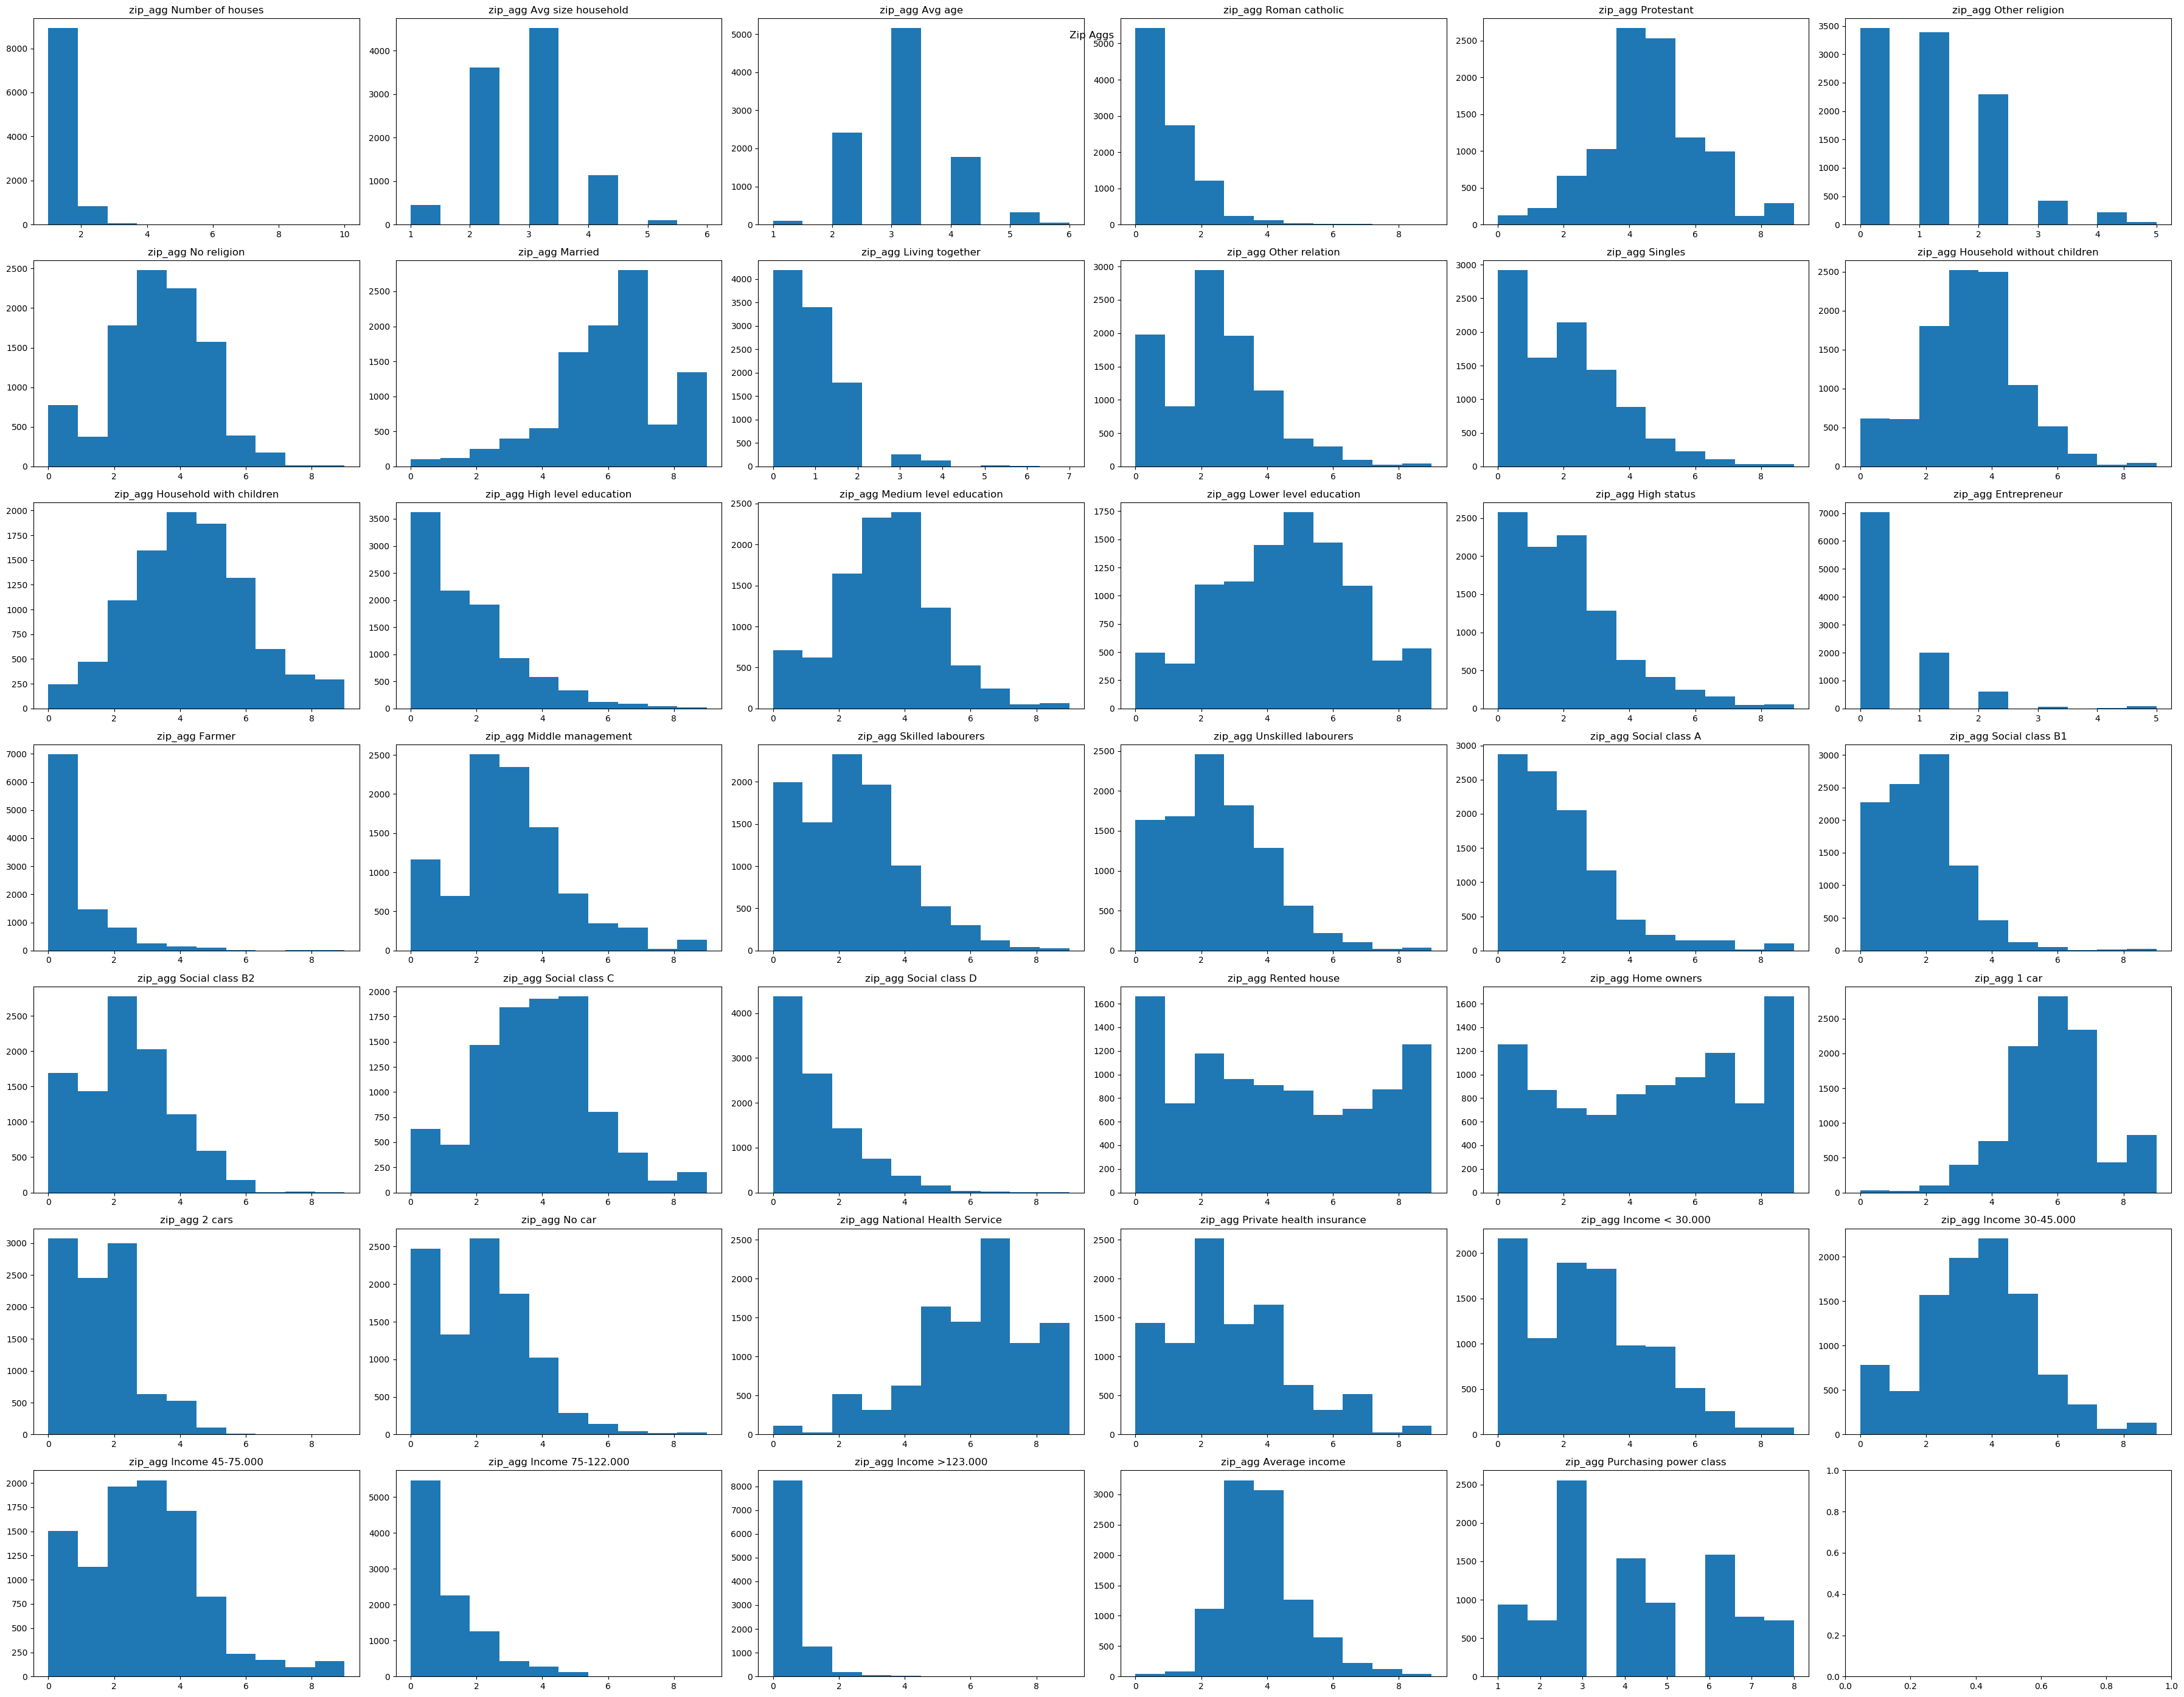

In [10]:
create_plots_sub(df, feat_names=[col for col in df if ((col.startswith('zip_agg')) & (df[col].dtype=='int64'))], plot_title='Zip Aggs')

#### Non binned frequencies

Comparing the above distrubutions for the aggregated zip code features to the rest of the numeric features, it becomes a little clearer why I found the aggregated ones odd. The rest of the numeric features have a greater range of values, are weighted more toward the low end (I've found that many real world features tend toward 0 or 1 when they're counts), and appear to be missing many individual values.

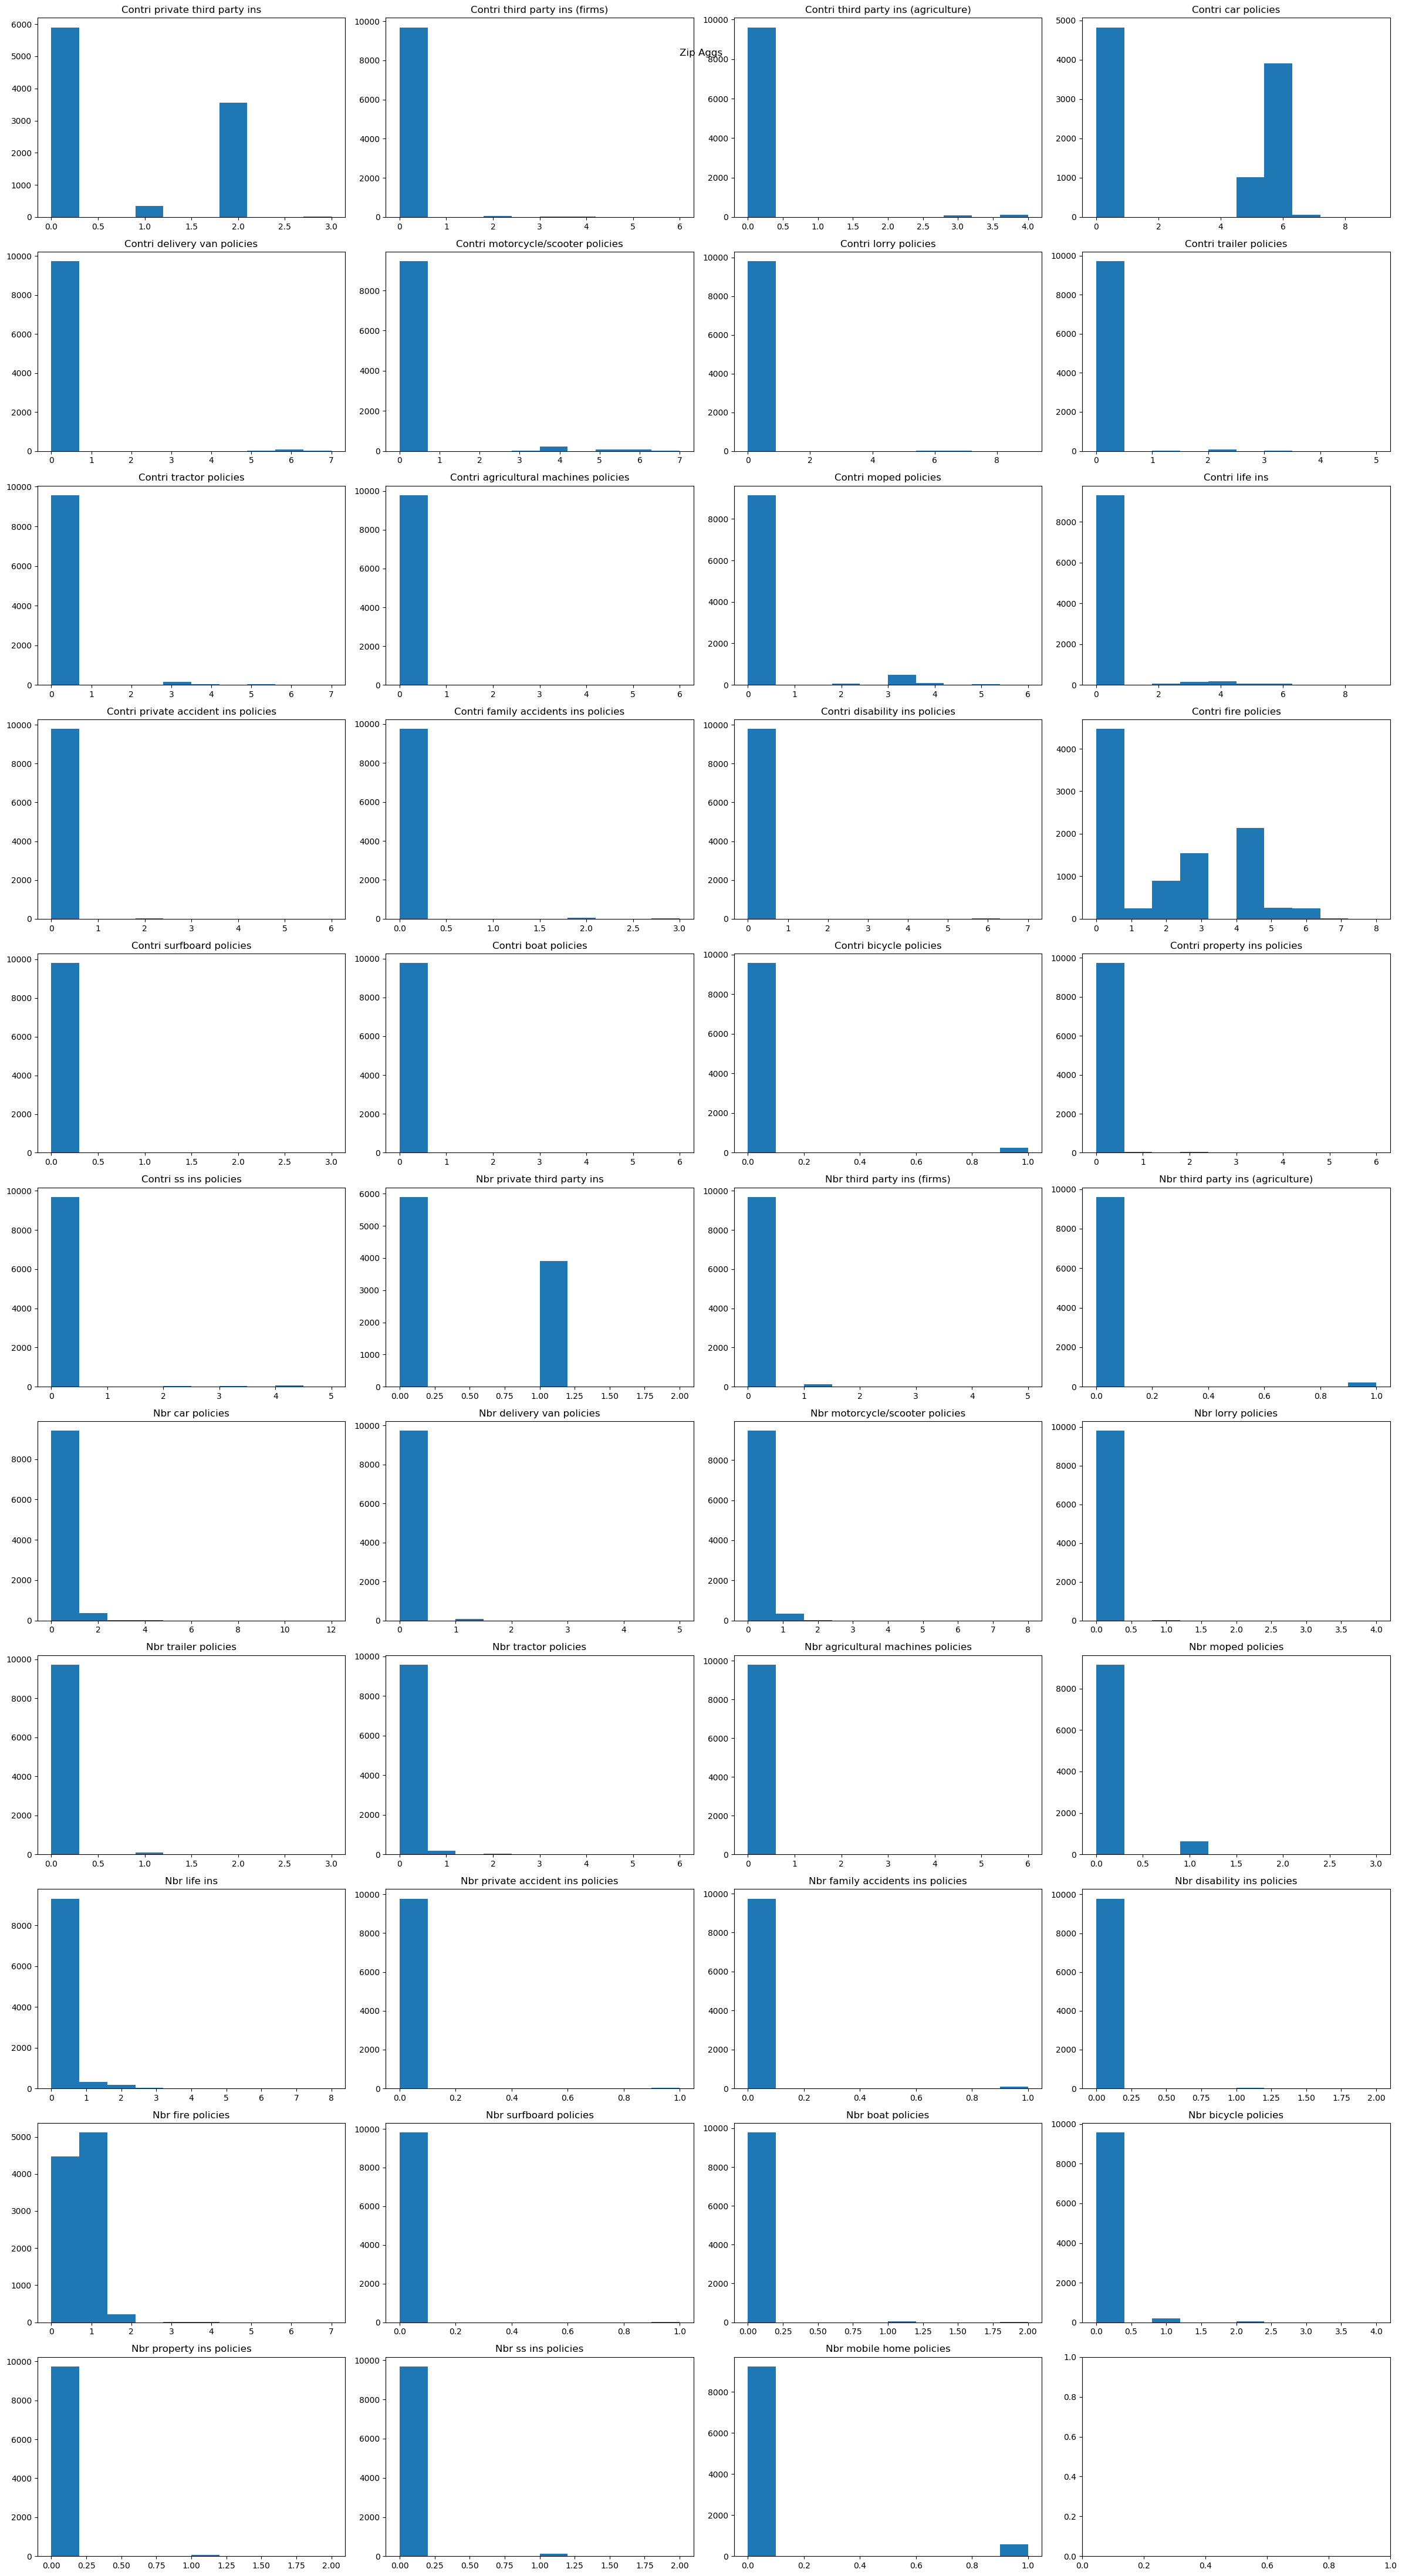

In [14]:
create_plots_sub(df, feat_names=[col for col in df if ((df[col].dtype=='int64') and not (col.startswith('zip_agg')))], col_plots=4, plot_title='Zip Aggs')

In [13]:
df.describe()

,zip_agg Number of houses,zip_agg Avg size household,zip_agg Avg age,zip_agg Roman catholic,zip_agg Protestant,zip_agg Other religion,zip_agg No religion,zip_agg Married,zip_agg Living together,zip_agg Other relation,...,Nbr private accident ins policies,Nbr family accidents ins policies,Nbr disability ins policies,Nbr fire policies,Nbr surfboard policies,Nbr boat policies,Nbr bicycle policies,Nbr property ins policies,Nbr ss ins policies,Nbr mobile home policies
count,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,...,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.000000,9822.00000,9822.000000,9822.000000,9822.000000
mean,1.108735,2.677561,2.996437,0.700672,4.637650,1.050092,3.262981,6.188964,0.873142,2.286602,...,0.004582,0.007941,0.004276,0.574018,0.000916,0.005091,0.03146,0.008450,0.013846,0.059662
std,0.412101,0.780701,0.804660,1.015107,1.721212,1.011156,1.606287,1.896070,0.961955,1.710674,...,0.067535,0.088764,0.071224,0.561255,0.030258,0.077996,0.20907,0.092647,0.117728,0.236872
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,1.000000,2.000000,2.000000,0.000000,4.000000,0.000000,2.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,1.000000,3.000000,3.000000,0.000000,5.000000,1.000000,3.000000,6.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,1.000000,3.000000,3.000000,1.000000,6.000000,2.000000,4.000000,7.000000,1.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,10.000000,6.000000,6.000000,9.000000,9.000000,5.000000,9.000000,9.000000,7.000000,9.000000,...,1.000000,1.000000,2.000000,7.000000,1.000000,2.000000,4.00000,2.000000,2.000000,1.000000


In [12]:
df.describe().T
# df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
zip_agg Number of houses,9822.0,1.108735,0.412101,1.0,1.0,1.0,1.0,10.0
zip_agg Avg size household,9822.0,2.677561,0.780701,1.0,2.0,3.0,3.0,6.0
zip_agg Avg age,9822.0,2.996437,0.804660,1.0,2.0,3.0,3.0,6.0
zip_agg Roman catholic,9822.0,0.700672,1.015107,0.0,0.0,0.0,1.0,9.0
zip_agg Protestant,9822.0,4.637650,1.721212,0.0,4.0,5.0,6.0,9.0
...,...,...,...,...,...,...,...,...
Nbr boat policies,9822.0,0.005091,0.077996,0.0,0.0,0.0,0.0,2.0
Nbr bicycle policies,9822.0,0.031460,0.209070,0.0,0.0,0.0,0.0,4.0
Nbr property ins policies,9822.0,0.008450,0.092647,0.0,0.0,0.0,0.0,2.0
Nbr ss ins policies,9822.0,0.013846,0.117728,0.0,0.0,0.0,0.0,2.0


In [16]:
print('Smallest minimum:', df.describe().transpose()['min'].min())
print('Largest maximum:', df.describe().transpose()['max'].max())

Smallest minimum: 0.0
Largest maximum: 12.0


### Categorical features

I also dove into the categorical values using this view. Now that I can see how the categorical values are distributed, I get the impression that the individual categories aren't exclusive. For example, in the `zip_agg Customer Subtype` feature couldn't a 'Young all american family' (302 instances) also be a 'Stable family' (271 instances)?

The `zip_agg Customer main type` values are all over the place, neither refering to just economic status or age or political leaning, but a weird amalgamation of everything.

These are the kinds of issues I watch out for when creating features using production data. Categorical values should be well defined and not overlap. If multiple values apply to the same observation, there are ways to represent this then separate it out into individual features using the [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html). Details of this processing are outside the scope of this post.

In [12]:
for col in df.columns:
    if df[col].dtype=='object':
        print(col)
        display(df[col].value_counts(dropna=False))
        print('\n')

zip_agg Customer Subtype


Lower class large families                    1401
Traditional families                           569
Middle class families                          546
Large religous families                        542
Modern, complete families                      460
High status seniors                            433
Young and rising                               376
Couples with teens 'Married with children'     373
Village families                               362
Mixed rurals                                   355
Large family, employed child                   325
Young, low educated                            324
Low income catholics                           318
Mixed seniors                                  304
Young all american family                      302
Family starters                                286
Stable family                                  271
Mixed small town dwellers                      233
High Income, expensive child                   218
Career and childcare           



zip_agg Customer main type


Family with grown ups    2694
Average Family           1513
Conservative families    1111
Successful hedonists      959
Living well               940
Retired and Religeous     881
Driven Growers            827
Farmers                   492
Cruising Seniors          326
Career Loners              79
Name: zip_agg Customer main type, dtype: int64